# ROMS Tutorial 3: more complex plotting

by David Gwyther

This tutorial will focus on some slightly more complex (and pretty) plots

In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/local/m68/deg581/tmp'

## load data

In [2]:
# load single ROMS netcdf with xr
ds = xr.open_dataset('/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08009.nc')
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317, xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272, eta_psi: 316, xi_psi: 271, ocean_time: 31)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-06 ... 2011-12-11
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/90)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    shflux         (ocean_time, eta_rho, xi_rho) float32 ...
    ssflux         (ocean_time, eta_rho, xi_rho) float32 ...
    sustr          (ocean_time, eta_u, xi_u) float32 ...
    svstr          (ocean_time, eta_v, xi_v) float32 ...
    bustr          (ocean_time, eta_u, xi_u) float32 ...
    bvstr          (ocean_time, eta_v, xi_v) float32 ...
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## let's first process our dataset and make a grid file

In [3]:
# do special processing for ROMS formatting


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

ds = processROMSGrid(ds)

grid = makeROMSGridObject(ds)

## our simple plan-view plot

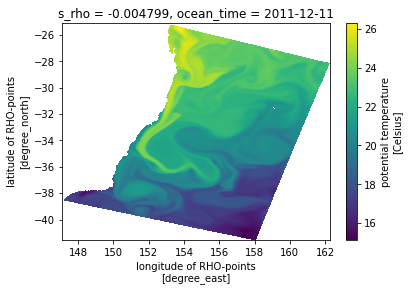

In [4]:
ds.temp.isel(s_rho=-1,ocean_time=-1).plot(x='lon_rho',y='lat_rho')

## a nicer plan view - thanks Neil!

<Figure size 432x288 with 0 Axes>

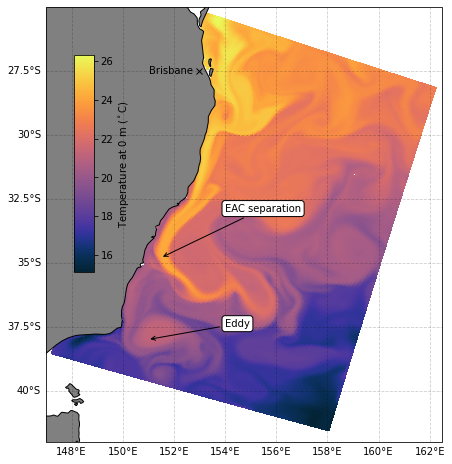

In [5]:
# out data to plot is declared upfront for ease
toPlotData=ds.temp.isel(s_rho=-1, ocean_time=-1)

# make our plotting space with gridspec
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None

#make an axis
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())

pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}

# add coastline and roms data
ax.set_extent([147, 162.5, -42, -25])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.thermal')   

# and annotations
ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='x',color='k')
arr_props=dict(arrowstyle="->",connectionstyle="arc3")
box_style=dict(boxstyle="round", fc="w")
ax.annotate("Eddy",xy=(151,-38),xycoords='data',xytext=(154,-37.5),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("EAC separation",xy=(151.5,-34.8),xycoords='data',xytext=(154,-33),textcoords='data',arrowprops=arr_props,bbox=box_style)

# remove the auto-generated title
ax.set_title('')

# set up gridlines
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False

#add colourbar
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Temperature at 0 m ($^\circ$C)')
ax = plt.gca()

Text(0.5, 1.05, 'Ref state')

<Figure size 432x288 with 0 Axes>

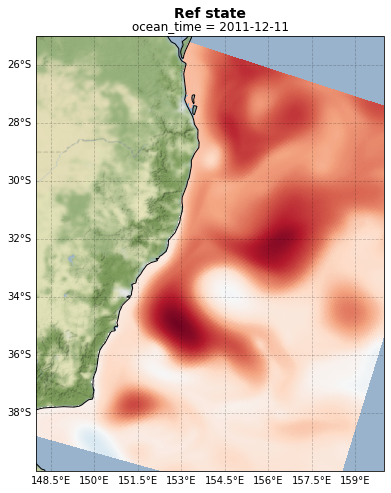

In [6]:
# Can add coloured background map
import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.Stamen('terrain-background')



gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 6)
ax.add_feature(Coast, edgecolor='black')
ds.zeta.isel(ocean_time=-1).plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='RdBu_r',vmin=-1,vmax=1)
ax.set_extent([148, 160, -40, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)



## contour plot

Text(0.5, 1.05, 'Ref state')

<Figure size 432x288 with 0 Axes>

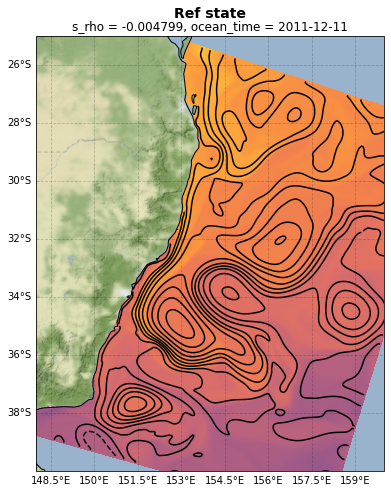

In [7]:
# Can add coloured background map
import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.Stamen('terrain-background')



gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 6)
ax.add_feature(Coast, edgecolor='black')
ds.temp.isel(s_rho=-1,ocean_time=-1).plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.thermal',vmin=5,vmax=30)
# add contours using the matplotlib command rather than the inbuilt xarray version:
ax.contour(ds.lon_rho,ds.lat_rho,ds.zeta.isel(ocean_time=-1),levels=np.arange(-1,1,.1),colors='k')
ax.set_extent([148, 160, -40, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)



## streamline plots

<Figure size 432x288 with 0 Axes>

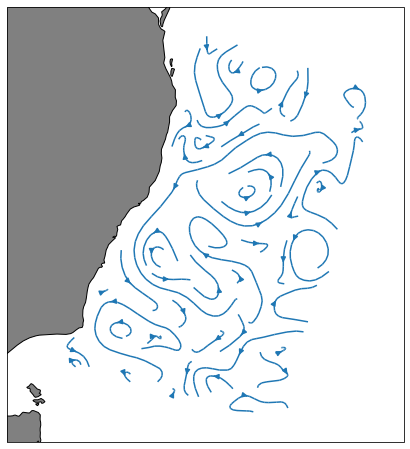

In [8]:
# a simple demonstration of streamlines from u and v velocity fields:
# note that you have to give plt.streamplot the .values not just the xarray datasets

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=-0.35, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,8])
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
plt.streamplot(ds.lon_rho.values, ds.lat_rho.values, ds.u_eastward.isel(s_rho=-1).mean(dim='ocean_time').values, ds.v_northward.isel(s_rho=-1).mean(dim='ocean_time').values)



Text(0.5, 1.0, '')

<Figure size 432x288 with 0 Axes>

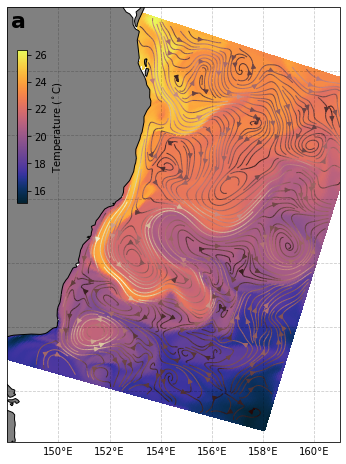

In [9]:
# a full example of streamplot over the top of other data

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None


# declare this velocity magnitude field that we use for colouring our streamlines
snap_shot = ds.isel(ocean_time=-1)
snap_shot["umag"] = np.sqrt(snap_shot.u_eastward.isel(s_rho=-1).squeeze()**2+snap_shot.v_northward.isel(s_rho=-1).squeeze()**2)

# other streamplot options:
str_kwargs = {"color":snap_shot.umag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":4,
              "cmap":"pink",
             "transform":ccrs.PlateCarree()}

pcol_kwargs = {"cmap":"cmo.thermal"}


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([148, 161, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ax.pcolormesh(snap_shot.lon_rho,snap_shot.lat_rho,snap_shot.temp.isel(s_rho=-1),cmap='cmo.thermal')
st = ax.streamplot(snap_shot.lon_rho.values, snap_shot.lat_rho.values, snap_shot.u_eastward.isel(s_rho=-1).values, snap_shot.v_northward.isel(s_rho=-1).values,**str_kwargs)
gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = True
cax = inset_axes(ax,
            width="3%",  # width = 10% of parent_bbox width
            height="50%",  # height : 50%
            loc='lower left',
            bbox_to_anchor=(.03,.55, 1, .7),
            bbox_transform=ax.transAxes,
            borderpad=0,
            )
cbar = fig.colorbar(im, cax=cax)
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_title('')

cbar.set_label('Temperature ($^\circ$C)')
ax.set_title('')  